# Regresión lineal

Este trabajo practico es un [Jupyter Notebook](https://jupyter.org/). Se ejecuta en "Google Colab" o en "jupyter". Puede ejecutar cada bloque de código seleccionando control+enter repetidamente, o seleccionando el icono "reproducir"

## Importar librerías de python

Primero importamos los paquetes de software necesarios. Incluyen [numpy](https://numpy.org/doc/stable/) y [pytorch](https://pytorch.org/).


In [ ]:
# Primero importamos las herramientas que usaremos. Siempre que sea posible, siempre vale la
# pena usar las herramientas existentes, incluso si las matemáticas son fáciles de escribir.
import numpy as np
import matplotlib.pyplot as plt
import torch
from sys import exit
torch.manual_seed(15); #Sets the seed for generating random numbers. Returns a torch.Generator object.


## Generación de datos

Como primer ejemplo de cómo funciona un modelo de regresión, generamos un conjunto de datos sintéticos con una relación funcional conocida y un error observacional generado aleatoriamente con distribución gaussiana

$$ y = f( x ) + \epsilon(x) $$

$$ \epsilon(x) \sim \mathcal N (0,\sigma^2) $$


In [ ]:
fn = lambda x: 0.5 + x - 0.2 * torch.sin(2*torch.pi*(0.7*x)**2)
#noise = lambda x: (0.08 * x+0.02) * torch.randn(x.shape[0])
noise = lambda x: 0.1 * torch.randn(x.shape[0])

#  Escribimos una función que permite generar los datos sintéticos
def generate(n_samples):
    x=torch.linspace(0,1,n_samples)
    y = fn(x) +noise(x)
    return x[:,None],y[:,None]
#MP Esto debe ser de dos dimensiones para que pueda generalizarse a calculos varias variables en pytorch

In [ ]:
x_train,y_train=generate(10) # Datos para entrenamiento
x_val,y_val=generate(60) # Datos para validación
y_true = fn(x_val) # True - verdad
#  Los datos que definimos son tensores de pytorch

*Normalizacion o escaling de los datos*

En general es conveniente que las variables de entrada tengan una escala similar. Existen varias formas de hacer esto, transformar todos los datos a la escala de 0 a 1 o transformar los datos a una normal estandard, es decir para que la media sea 0 y la varianza 1.

Aplicamos la primera para ilustración, aún cuando para una variable $y$ en el rango de 0 a 1 no es necesario.


In [ ]:
def MinMaxScaler(x):
    return (x-x.min())/(x.max()-x.min())

x_train=MinMaxScaler(x_train)
x_val=MinMaxScaler(x_val)

In [ ]:
class dat:# apilo los datos en una clase; para posible uso posterior
    x_train=x_train; y_train=y_train
    x_val=x_val; y_val=y_val; y_true=y_true

Graficamos los datos sintéticos y la función verdadera.

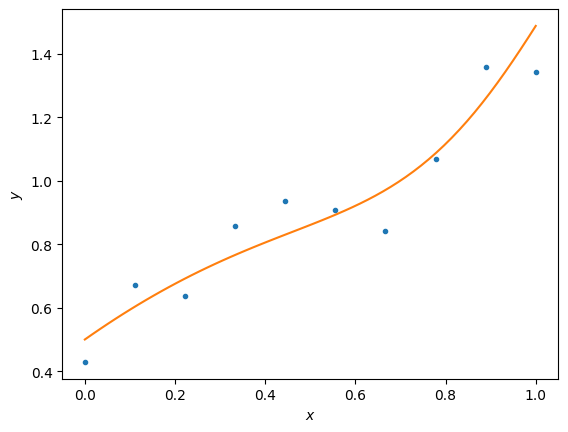

In [ ]:
# Graficamos la función verdadera con los datos de entrenamiento
plt.plot(x_train,y_train,'C0.',label='Datos')
plt.plot(x_val,y_true,'C1',label='Verdad')#,'.')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

## Solución analítica
$\renewcommand{\v}[1]{{\mathbf{#1}}}$

El error de predicción, o función de pérdida, se define como la distancia Euclidea entre la predicción de nuestro modelo y los datos. Para el caso unidimensional,

$$ J(\v w) = \frac{1}{2 N}\sum_{n=1}^N [y_n - f(\v x_n,\v w)]^2 $$
donde $N$ es el número de datos.

Si proponemos una superposición lineal de funciones base, los parámetros óptimos del problema de regresión lineal se pueden obtener analíticamente.

La matriz de diseño se define por:


\begin{equation}
\v \Phi =
\begin{pmatrix}
 \Phi_1(\v x_1) & . . . . & \Phi_{M}(\v x_1)\\
 \Phi_1(\v x_2) & . . . . & \Phi_{M}(\v x_2)\\
 :  &  :  &  : \\
  :  &  :  &  : \\
\Phi_1(\v x_N) & . . . . & \Phi_{M}(\v x_N)
\end{pmatrix}
\end{equation}


Los parámetros óptimos del problema se obtienen analíticamente a partir de la raíz del gradiente de la función de pérdida:

$$ \v w= \left( \v \Phi^\top \v \Phi\right)^{-1} \v \Phi^\top \v Y$$

En nuestro caso particular, $\v Y \in \mathbb R^{N \times 1}$ y la matriz de diseño $\v \Phi \in \mathbb R^{N \times M}$ y $\v x_i \in \mathbb R^{K \times 1}$, donde $K$ es el número de entradas por cada salida.

Si proponemos los polinomios hasta segundo grado, la matriz de diseño está definida por:
\begin{equation}
\v X =
\begin{pmatrix}
1 & x_1 & x_1^2\\
1 & x_2 & x_2^2\\
: &  : &  : \\
1 & x_N & x_N^2
\end{pmatrix}
\quad \quad \quad
\v Y =
\begin{pmatrix}
y_1\\
y_2\\
 : \\
y_N
\end{pmatrix}
\quad \quad \quad
\v w =
\begin{pmatrix}
w_0\\
w_1\\
w_2
\end{pmatrix}
\end{equation}

In [ ]:
def design_recta(x):
    ' matriz de diseño para la recta '
    return torch.stack((torch.ones(x.shape[0]),x[:,0]),1)

def design_rectaND(x):
    ' matriz de diseño para la recta '
    return torch.hstack((torch.ones(x.shape[0],1),x))


def pesos_analiticos(x_dat,y_dat,design=design_recta):
    ' Obtiene los pesos del modelo lineal en forma analítica'
    X=design(x_dat)
    print(X.shape)

    A = torch.linalg.pinv(X.T @ X) @ X.T
    #torch.linalg.pinv --> Computes the pseudoinverse (Moore-Penrose inverse) of a matrix.
    #.T --> transpuesta
    #@ -- > multiplicacion de matrices
    w_opt=A@y_dat
    return w_opt


In [ ]:
def Design(choice,ng):
    def polinom(x):
        ' Polinomios '
        x_aug=[x[:,0]**i for i in range(1,ng+1)]
        phi=torch.stack(x_aug)
        return phi.T
    def rbf(x):
        ' Generate a design matrix of radial basis functions '
        mu=torch.linspace(x.min(),x.max(),ng)
        alpha=1./torch.sqrt((mu[1]-mu[0])**2)# configurable parameter
        phi = torch.exp(-alpha*(x-mu[None,:])**2)
        return phi
    if choice == 'rbf': design=rbf
    else: design=polinom
    return design
    """Defino la matriz de diseño con functional programming
    llamo una vez para definir los parámetros y luego para evaluarla"""

# Ejemplo de Uso:

#diseno_polinom=Design('rbf',5)

#phi = diseno_polinom(x) # torch.linspace(0,1,100)[:,None])

In [ ]:
w_opt=pesos_analiticos(x_train,y_train)
phi=design_recta(x_val)

# Predicción con los parámetros óptimos
y_lin = phi @ w_opt

torch.Size([10, 2])


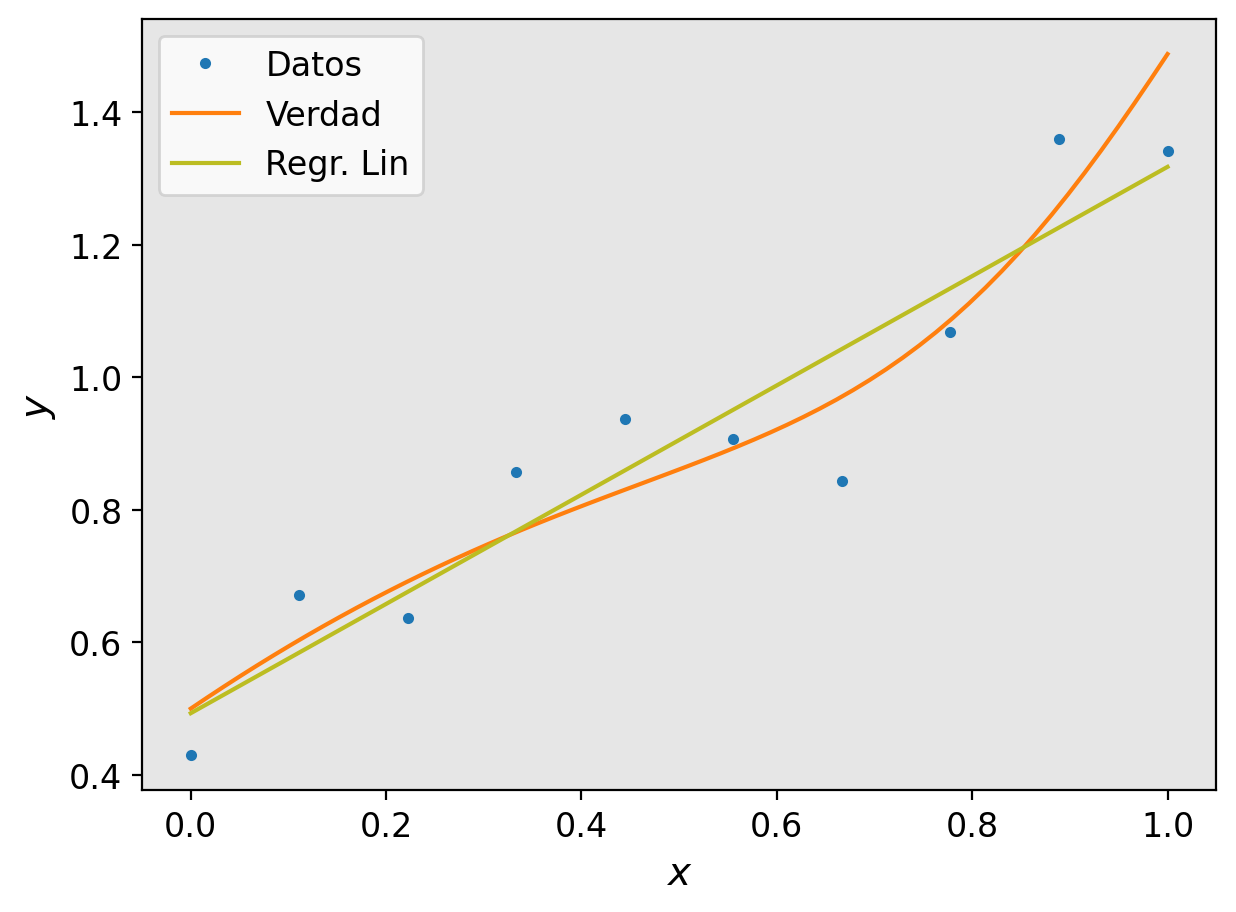

In [ ]:

plt.plot(x_train,y_train,'C0.',label='Datos')
plt.plot(x_val,y_true,'C1',label='Verdad')
plt.plot(x_val,y_lin,'C8',label='Regr. Lin')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.tight_layout()
plt.legend();
plt.savefig('../tmp/anaLinReg.png')

### <font color='red'> Tarea 1 </font>

Realice una función similar a `pesos_analiticos_recta` pero que permita ajustar los datos a un polinomio cúbico. Grafique el resultado.

## Aprendizaje con descenso del gradiente (artesanal)

Otra forma de encontrar los parámetros óptimos es utilizar un algoritmo iterativo que minimice la función de pérdida $J(\v w)$. El método de optimización numérica  mas sencillo es el de **descenso del gradiente**. Este es un método de optimización que usa la información del gradiente de la función de costo.

Los métodos de optimización y en particular, el descenso de gradientes, sirven para modelos no lineales en los cuales no existe solucion analítica de los parámetros óptimos, por lo que será fundamental para el aprendizaje automático de redes neuronales.

En nuestro caso particular, aplicamos el método del descenso del gradiente para realizar la actualización de los parámetros
$$\v w =   \v w - \eta \nabla_w J$$
con una tasa de aprendizaje fija.

*   Usamos ‘$-$‘ (resta), para ir en la dirección opuesta al gradiente.
*   La actualización de $\v w$ es proporcional al gradiente (a mayor pendiente [más empinado], mayor es el cambio).
*   $\eta$, también llamada ‘tasa de aprendizaje’, controla la velocidad de la actualización.

La tasa de aprendizaje (learning rate en inglés) debe ajustarse: si la tasa de aprendizaje es demasiado grande, los cambios en $w$ serán también muy grandes y será difícil encontrar los coeficientes que minimicen la función de pérdida.



### Código:
Vamos a definir el modelo lineal, la función de costo y el gradiente de la función de costo. Luego, hacemos iteraciones con descensos de gradientes a partir de parámetros iniciales elegidos al azar.


In [ ]:
def lin_model (w,phi):
    return phi @ w

Seguimos definiendo la función de costo.

In [ ]:
def loss_fn(y_pred,y_obs): # función de costo: MSE
    return 0.5*torch.mean((y_pred-y_obs)**2)

Continuamos definiendo el cálculo del gradiente. A continuación presentamos dos posibilidades, uno es más sencillo de entender y el otro requiere mayor manejo de pytorch.

In [ ]:
def nablaJ(w,phi,y_obs):
    """
    calculo el gradiente de la función de pérdida
    en función de los pesos
    """
    y_pred=lin_model(w,phi)
    dJdf = y_pred-y_obs
    dJdw = torch.mean(phi*dJdf[None,...],1).T
    # dJdw = phi.T @ dJdf / phi.shape[0] # alternativa
    return dJdw

Ahora viene el entrenamiento

In [ ]:
# Entrenamiento
def train_manual(w, dat, design=design_recta, n_epochs=2000,eta=1.e-2):
    Jtrain=[]; Jval=[]
    print(w)
    for i in range(n_epochs):

        phi_train = design(dat.x_train)
        w = w - eta * nablaJ(w,phi_train,dat.y_train)

        Jtrain+=[loss_fn(lin_model(w,phi_train),dat.y_train).item()]

        phi_val = design(dat.x_val)

        Jval+=[loss_fn(lin_model(w,phi_val),dat.y_val).item()]

        if n_epochs > 100 :
            if i == 100 :  w_1=w
        else :
            w_102=0

        if n_epochs > 1000 :
            if i == 1000 :  w_2=w
        else :
            w_104=0

        num=n_epochs/10
        if i%num == 0:
            print(round(Jtrain[i],3),round(Jval[i],3))
            print(w)

    return w,w_1,w_2,Jtrain,Jval

Función para la graficación de la evolución de la función de costo y comparamos la predicción con la verdad.

In [ ]:
# Grafico la función de costo y la predicción
def train_plot(loss_train,loss_val,y_pred_val,y1,y2,dat):
    fig=plt.figure(figsize=(15,6))
    plt.rcParams.update({'font.size': 14})
    p1=fig.add_subplot(1,2,1)
    p1.plot(loss_train, 'r',label='Train')
    p1.plot(loss_val, 'g',label='Validation')
    p1.set_yscale('log')
    p1.set_xscale('log')
    p1.grid('True', color='y')
    p1.set_xlabel("Epochs/Iterations")
    p1.set_ylabel("Loss")
    plt.legend();
    p1=fig.add_subplot(1,2,2)
    p1.plot(dat.x_train, dat.y_train, 'C0.',label='Train Data')
    p1.plot(dat.x_val, dat.y_true,'C1',label='True')
    p1.plot(dat.x_val, dat.y_val, 'C3.',label='Val Data')
    p1.plot(dat.x_val, y_pred_val,'C2',label='Gradiente')
    p1.plot(dat.x_val, y1,'C4',label='Grad 1')
    p1.plot(dat.x_val, y2,'C5',label='Grad 2')
    plt.plot(dat.x_val,y_lin,'C8',label='Óptimos')
    p1.legend()
    p1.set_xlabel(r'$x$');
    p1.set_ylabel(r'$y$');
    fig.tight_layout()

Realizo el entrenamiento y análisis para el caso lineal.

tensor([[-0.4657],
        [-0.9049]])
tensor([[-0.4657],
        [-0.9049]])
1.774 1.728
tensor([[-0.4475],
        [-0.8940]])
0.006 0.008
tensor([[0.5951],
        [0.6365]])
0.005 0.006
tensor([[0.5136],
        [0.7864]])
0.005 0.006
tensor([[0.4972],
        [0.8166]])
0.005 0.006
tensor([[0.4939],
        [0.8227]])
0.005 0.006
tensor([[0.4932],
        [0.8239]])
0.005 0.006
tensor([[0.4931],
        [0.8241]])
0.005 0.006
tensor([[0.4931],
        [0.8242]])
0.005 0.006
tensor([[0.4931],
        [0.8242]])
0.005 0.006
tensor([[0.4931],
        [0.8242]])
grad 1 tensor([[ 0.5582],
        [-0.2545]])
grad 2 tensor([[0.7204],
        [0.4060]])
gradiente tensor([[0.4931],
        [0.8242]])
optimos   tensor([[0.4931],
        [0.8242]])


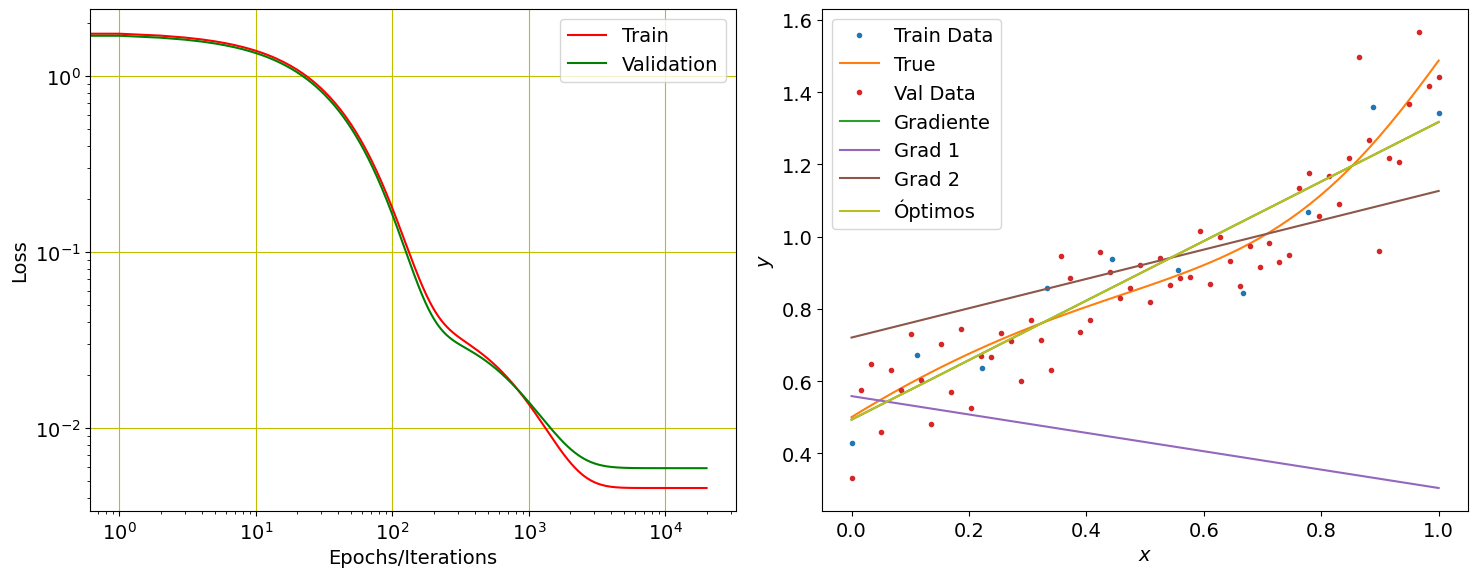

In [ ]:
design=design_recta #  puede ser otra (polinomios/RBFs)
w=torch.randn(2) # inicializacion de los pesos
w=w[:,None]
print(w)
w,w_1,w_2,Jtrain,Jval = train_manual(w,dat,design=design,n_epochs=20000,eta=1.e-2)
#print(w.shape)
#print(x_val.shape)
phi_val = design(dat.x_val)
ymodel = lin_model(w,phi_val)
ym1 =  lin_model(w_1,phi_val)
ym2 =  lin_model(w_2,phi_val)

train_plot(Jtrain,Jval,ymodel,ym1,ym2,dat)
print('grad 1', w_1)
print('grad 2',w_2)
print('gradiente', w)
print('optimos  ', w_opt)


### <font color='red'> Tarea 2 </font>

+ Defina la función 'design' con un polinomio de grado 3. Realice un entrenamiento de 100.000 iteraciones. Grafique las funciones de pérdida del conjunto de entrenamiento y el de validación. Grafique la estimaciones en 100 iteraciones, 10.000 iteraciones y en 100.000. ¿Qué conclusiones saca? Compare con los parámetros obtenidos analíticamente.
+ Ahora defina la  función 'design' con un polinomio de grado 10. Realice un entrenamiento de 100.000 iteraciones. Grafique las funciones de pérdida del conjunto de entrenamiento y el de validación. Grafique la estimaciones en 100 iteraciones, 10.000 iteraciones y en 100.000. ¿Qué conclusiones saca? Compare con el item anterior. Discuta sobre el overfitting. ¿Cuál es la capacidad mínima requerida en el modelo?

In [ ]:
# Celda para el ejercicio

## Definiendo un modelo lineal en pytorch


pytorch es una potente herramienta que nos permite trabajar en la GPU y realiza mucho de los cálculos en forma automática. En particular, tiene un autograd que nos permite calcular gradientes de cualquier tipo de modelo. Veamos cómo definimos un modelo en pytorch.

In [ ]:
class polinom_model(torch.nn.Module):
    " Modelo polinomial en pytorch"
    def __init__(self,n_inputs,n_outputs):
        'n_inputs me definira el grado del polinomio. Asumo 1 variable '
        super().__init__()
        self.n_inputs=n_inputs
        print('Degree:',n_inputs)
        self.lm = torch.nn.Linear(n_inputs-1,n_outputs,bias=True)

    def forward(self, x):
        " Agrego como features los terminos del polinomio de grado n_inputs-1 "
        x_aug=[x[:,0]**i for i in range(1,self.n_inputs)]
        x_aug=torch.stack(x_aug)
        return self.lm(x_aug.T)


Notar que requerimos trabajar con clases en pytorch. La inicializacion del objeto nos permite definir los parámetros del modelo. Los pesos son inicializados en forma implícita (a través de la clase madre).  `torch.nn.Linear` nos define el modelo lineal. Este multiplica el $x$ por los pesos: $y=x w^T + b$ donde b es el bias.

In [ ]:
class rbf_model(torch.nn.Module):
    " Modelo de RBFs en pytorch"
    def __init__(self,n_inputs,n_outputs):
        'n_inputs me definira el grado del polinomio. Asumo 1 variable '
        super().__init__()
        self.n_inputs=n_inputs
        print('Degree:',n_inputs)
        self.lm = torch.nn.Linear(n_inputs-1,n_outputs,bias=True)
    def forward(self, x):
        ' Los features of the radial basis functions '
        mu=torch.linspace(x.min(),x.max(),ng)
        alpha=1./torch.sqrt((mu[1]-mu[0])**2)# configurable parameter
        phi = torch.exp(-alpha*(x-mu[None,:])**2)
        return self.lm(phi.T)


Los modelos siempre tienen la misma estructura, mismos atributos y funciones. Notar que lo que cambia es el método forward. El método forward es el que se llama por default en la clase es decir es el `__call__`

## Training

A los modelos de pytorch los podemos entrenar sin preocuparnos por el modelo ni el gradiente, veamos una función de entrenamiento totalmente genérica.

In [ ]:
def train(model,n_epochs):
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # Descenso de gradientes
    loss_fn = torch.nn.MSELoss() # funcion de perdida idem a la anterior
    lossl=[]; lossv=[]
    for i in range(n_epochs):

        # Calculate predicted y from x
        y_pred = model(x_train) # Estamos llamando al forward del modelo

        # Calculate loss
        loss = loss_fn(y_pred,y_train)
        if i%100 == 0: print(f'epoch: {i:4}, loss: {loss.data:.3}',)

        lossl.append(loss.item())

        # Backprop, first initialize with zero gradients
        optimizer.zero_grad()
        loss.backward()

        # Update parameters
        optimizer.step() # w  = w - eta * dJdw

        with torch.no_grad(): # para validacion no usar los gradientes
            y_pred = model(x_val)
            loss = loss_fn(y_pred,y_val)
            lossv.append(loss.item())
    return lossl, lossv


Notar que estamos usando zero_gra para inicializar el gradiente, backward para calcular dJdw y el step es el descenso de graidente. Y ahora se viene la magia.
Esta función de entrenamiento se podría usar para cualquier tipo de modelo (lineal, nolineal, redes etc.)

In [ ]:
model=polinom_model(10,1) # instancio el modelo y así inicializo los parámetros
loss_train,loss_val = train(model,30000) # entreno pasando el modelo a la funcion de entrenamiento.
with torch.no_grad(): # no training
    y_pred_val=model(x_val)

Degree: 10
epoch:    0, loss: 2.04
epoch:  100, loss: 0.956
epoch:  200, loss: 0.469
epoch:  300, loss: 0.247
epoch:  400, loss: 0.143
epoch:  500, loss: 0.0928
epoch:  600, loss: 0.0666
epoch:  700, loss: 0.0519
epoch:  800, loss: 0.0426
epoch:  900, loss: 0.0363
epoch: 1000, loss: 0.0317
epoch: 1100, loss: 0.0281
epoch: 1200, loss: 0.0252
epoch: 1300, loss: 0.0228
epoch: 1400, loss: 0.0209
epoch: 1500, loss: 0.0192
epoch: 1600, loss: 0.0179
epoch: 1700, loss: 0.0168
epoch: 1800, loss: 0.0158
epoch: 1900, loss: 0.015
epoch: 2000, loss: 0.0144
epoch: 2100, loss: 0.0138
epoch: 2200, loss: 0.0133
epoch: 2300, loss: 0.0129
epoch: 2400, loss: 0.0126
epoch: 2500, loss: 0.0123
epoch: 2600, loss: 0.0121
epoch: 2700, loss: 0.0119
epoch: 2800, loss: 0.0117
epoch: 2900, loss: 0.0115
epoch: 3000, loss: 0.0114
epoch: 3100, loss: 0.0113
epoch: 3200, loss: 0.0112
epoch: 3300, loss: 0.0111
epoch: 3400, loss: 0.011
epoch: 3500, loss: 0.0109
epoch: 3600, loss: 0.0109
epoch: 3700, loss: 0.0108
epoch: 38

# Datos Reales

Datos de 100 bebés. Pagano et al 2018 Principios de Bioestadística

Datos publicados en Leviton, Fenton, Kuban, y Pagano [1991], tratados en el libro de Pagano et al. [2000].

Los datos corresponden a mediciones de 100 niños nacidos con bajo peso (es
decir, con menos de 1500g.) en Boston, Massachusetts. Para dichos bebés se miden varias variables. La variable que nos interesa (la dependiente) es el perímetro cefálico al nacer (medido en cm.).


### Paso 1: Importar los datos

Se importan los datos del repositorio en github.

In [ ]:
#get the github repo
!git clone https://github.com/cjfrodas/samples.git
#cd into the repo so the paths work
import os
os.chdir('/content/')

Cloning into 'samples'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (11/11), 582.28 KiB | 2.28 MiB/s, done.
Resolving deltas: 100% (1/1), done.


### Paso 2: Procesamiento de los datos

Importamos Pandas, una biblioteca de Python utilizada para realizar análisis y manipulación de datos. Contiene el método .read_excel() que necesitamos para leer nuestro archivo xlsx.

Hacemos un chequeo de los datos.

<font color='red'> Faltaría el paso de buscar datos nulos. </font>

In [ ]:
#Leemos el conjunto de datos
import pandas as pd
datos=pd.read_excel("/content/samples/PERIM.CEFAL.xlsx")

print(type(datos))
#chequeo el conjunto de datos
print(datos)
print(datos.shape)


<class 'pandas.core.frame.DataFrame'>
    perimcefal  longitud  edadgesta  pesonacim  edadmadre
0           27        41         29       1360         37
1           29        40         31       1490         34
2           30        38         33       1490         32
3           28        38         31       1180         37
4           29        38         30       1200         29
..         ...       ...        ...        ...        ...
95          26        37         31        820         30
96          27        40         29       1150         28
97          28        35         32        880         35
98          28        41         33       1320         36
99          26        38         28       1080         36

[100 rows x 5 columns]
(100, 5)


Chequeo si hay datos nulos.

In [ ]:
#checking missing values
# X1 is the number of null values in each column
X1 = datos.isnull().sum().to_numpy()
print(X1)

[0 0 0 0 0]


Expresamos los datos como un tensor de pytorch.

In [ ]:
datorch = torch.tensor(datos.values,dtype=float) # MP Agrego!!
y_dat=datorch[:,0][:,None] #MP Agrego
x_dat=datorch[:,1:]
print(y_dat.shape)
print(x_dat.shape)

torch.Size([100, 1])
torch.Size([100, 4])


Defino algunos parámetros para los gráficos (prestado del curso del Centro Euopeo).

In [ ]:
import matplotlib
matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['legend.facecolor'] = 'w'
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'

Es una buena práctica ver los datos. Graficamos el perímetro cefálico al nacer vs distintas variables.

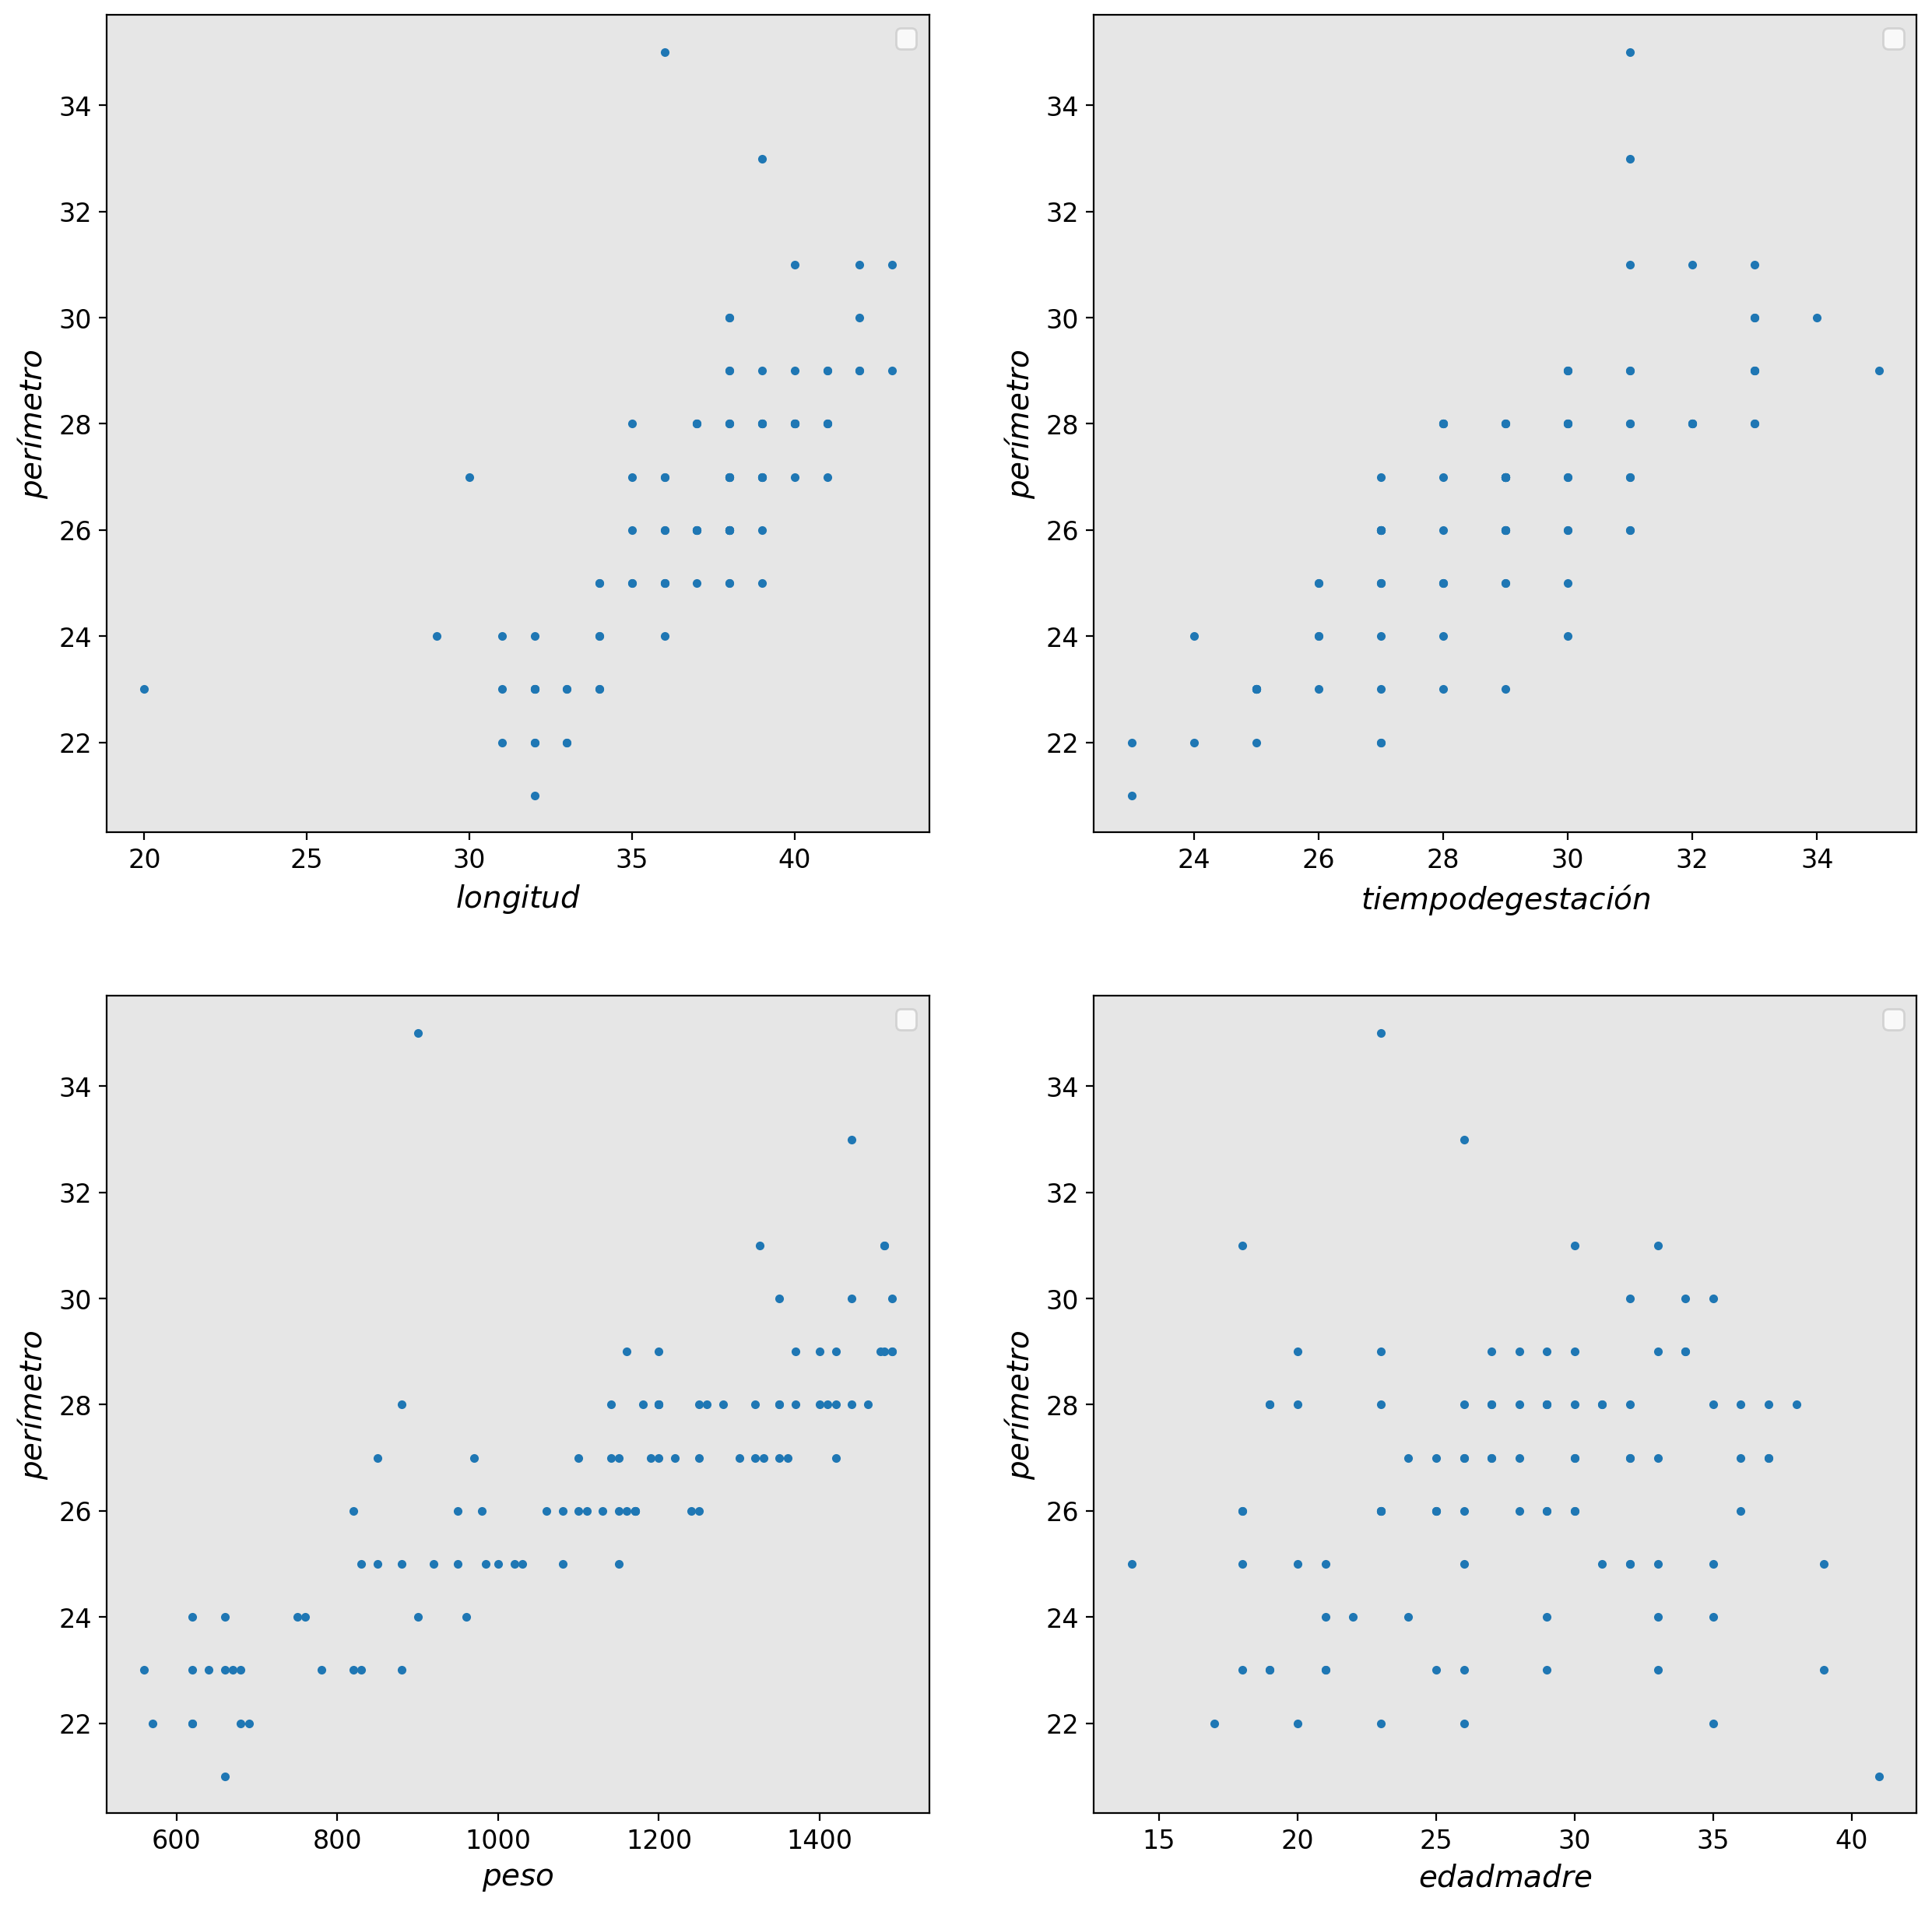

In [ ]:
fig=plt.figure(figsize=(15,15))
p1=fig.add_subplot(2,2,1)
p1.plot(x_dat[:,0],y_dat,'C0.')
p1.set_xlabel(r'$longitud$')
p1.set_ylabel(r'$perímetro$')
#p1.set_tight_layout()
p1.legend();
p1=fig.add_subplot(2,2,2)
p1.plot(x_dat[:,1],y_dat,'C0.')
p1.set_xlabel(r'$tiempo de gestación$')
p1.set_ylabel(r'$perímetro$')
#p1.tight_layout()
p1.legend();
p1=fig.add_subplot(2,2,3)
p1.plot(x_dat[:,2],y_dat,'C0.')
p1.set_xlabel(r'$peso$')
p1.set_ylabel(r'$perímetro$')
#p1.tight_layout()
p1.legend();
p1=fig.add_subplot(2,2,4)
p1.plot(x_dat[:,3],y_dat,'C0.')
p1.set_xlabel(r'$edad madre$')
p1.set_ylabel(r'$perímetro$')
#p1.tight_layout()
p1.legend();
#p1.savefig('../tmp/plot4.png')

Se observa que todos muestran algún tipo de relación lineal con el perímetro cefálico, excepto la edad de la madre (no tendremos en cuenta la edad de la madre entre nuestras variables).

Otra cosa que se observa es un par de datos atípicos. Quedará como tarea encontrar los parámetros sin tener en cueta estos datos.

En el paso siguiente, divido los datos para el entrenamiento y la validación. Esta división se hace en forma aleatoria. Además, me saco de encima la edad de la madre.

In [ ]:
index_number= np.random.permutation(100)
x1,y1=x_dat[index_number,0:3],y_dat[index_number] #me saco de encima la edad de la madre
x_train, x_val = x1[0:70,:], x1[70:100,:]
y_train, y_val=y1[0:70], y1[70:100]
print(x_train.shape)
print(x_val.shape)

torch.Size([70, 3])
torch.Size([30, 3])


### La importancia de escalar los datos al usar el Descenso del Gradiente

En el caso multidimensional, el descenso del gradiente funciona mucho mejor cuando los datos tienen una escala similar. Esto se debe a la forma geométrica de la función de costo. Cuando todas las dimensiones tiene una escala similar, podemos esperar la forma de cuenco multidimensional. Sin embargo, si distintas dimensiones tienen una escala diferente, la forma geométrica será muy diferente. Esto hace que el gradiente descendiente tarde mucho en converger.

In [ ]:
x_train = MinMaxScaler(x_train)
x_val = MinMaxScaler(x_val)
# Agrego a las variables el vector para el bias (caracteristicas)
X_train=torch.hstack((torch.ones(x_train.shape[0],1),x_train))
X_val=torch.hstack((torch.ones(x_val.shape[0],1),x_val))

class rdat:# apilo los datos en una clase; para posible uso posterior
    x_train=x_train; y_train=y_train
    x_val=x_val; y_val=y_val


Encuentro los parámetros óptimos por cuadrados mínimos. En particular para comparar luego con lo que se obtenga del descenso del gradiente.

In [ ]:
#diseno_polinom=Design('polinom',1)
#design=diseno_polinom
design=design_rectaND
wopt=pesos_analiticos(x_train,y_train,design=design) # ojo que es la design matrix?a
print(wopt)

torch.Size([70, 4])
tensor([[ 17.5603],
        [-50.1304],
        [717.6414],
        [  6.9400]], dtype=torch.float64)


In [ ]:
#design=design_rectaND #  puede ser otra (polinomios/RBFs)
w=torch.randn(x_train.shape[1]+1).type(torch.DoubleTensor) # inicializacion de los pesos
w=w[:,None]
print(w)
w,w_1,w_2,Jtrain,Jval = train_manual(w,rdat,design=design,n_epochs=200000,eta=1.e-2)
#print(w.shape)
#print(x_val.shape)
phi_val = design(rdat.x_val)
ymodel = lin_model(w,phi_val)
ym1 =  lin_model(w_1,phi_val)
ym2 =  lin_model(w_2,phi_val)
#if w_102 == 0 :
#    ym102 = 0
#else:
#    ym102 =  lin_model(w_102,phi_val)
#if w_104 == 0 :
#    ym104 = 0
#else:
#    ym104 =  lin_model(w_104,phi_val)
#train_plot(Jtrain,Jval,ymodel,ym1,ym2,dat)
print('grad 1', w_1)
print('grad 2',w_2)
print('gradiente', w)
print('optimos  ', wopt)
#train_plot(Jtrain,Jval,ymodel[:,0],dat)
#print(ymodel[:,0])

tensor([[1.1868],
        [0.6716],
        [1.2058],
        [0.4354]], dtype=torch.float64)
tensor([[1.1868],
        [0.6716],
        [1.2058],
        [0.4354]], dtype=torch.float64)
299.066 316.443
tensor([[1.4340],
        [0.6744],
        [1.2073],
        [0.6184]], dtype=torch.float64)
1.266 0.908
tensor([[18.3761],
        [ 0.9146],
        [ 1.5156],
        [10.7873]], dtype=torch.float64)
1.266 0.909
tensor([[18.3879],
        [ 0.9877],
        [ 1.7379],
        [10.7685]], dtype=torch.float64)
1.266 0.909
tensor([[18.3875],
        [ 1.0609],
        [ 1.9602],
        [10.7661]], dtype=torch.float64)
1.265 0.909
tensor([[18.3869],
        [ 1.1341],
        [ 2.1823],
        [10.7640]], dtype=torch.float64)
1.265 0.909
tensor([[18.3864],
        [ 1.2071],
        [ 2.4045],
        [10.7618]], dtype=torch.float64)
1.265 0.91
tensor([[18.3858],
        [ 1.2802],
        [ 2.6265],
        [10.7596]], dtype=torch.float64)
1.265 0.91
tensor([[18.3853],
        [ 1.3

En el gráfico que sigue se observa el valor estimado vs el valor observado para cada conjunto de variables.

Text(0.5, 0, 'medicion')

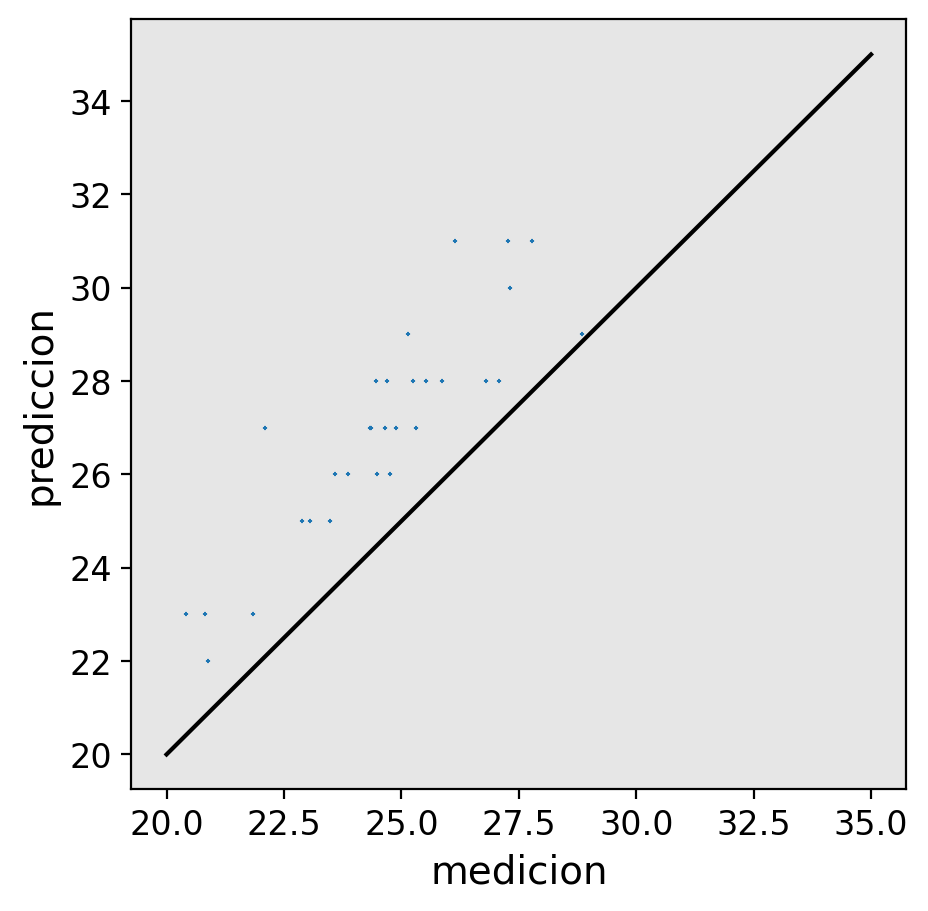

In [ ]:
#y_lin = X_val @ wopt
y_lin = X_val @ w
#make figure
fig = plt.figure(figsize=(5,5))
#set background color to white so we can copy paste out of the notebook if we want
fig.set_facecolor('w')

#get axis for drawing
ax = plt.gca()

#print(y_lin)

#plot data
ax.scatter(y_lin,y_val,s=1,marker='+')
ax.plot([20,35],[20,35],'-k')
ax.set_ylabel('prediccion')
ax.set_xlabel('medicion')

En el gráfico de arriba se observa lo medido vs los predicho, para una misma entrada (longitud, tiempo de gestación, peso). Se observa también una recta de pendiente 1 (lo que ocurriría para una predicción perfecta).

###<font color='red'> Tarea 3 </font>
* Hacer regresión por cuadrados mínimos y por descenso del gradiente sin tener en cuenta los datos atípicos. ¿Nota una mejora en la predicción?
* Ahora realice el ajuste con un polinomio de grado 2 (tener en cuenta que son varias variables). Realice entrenamientos con distintos número de iteraciones.
 Grafique las funciones de pérdida del conjunto de entrenamiento y el de validación.  ¿Qué conclusiones saca respecto al caso lineal?
